# Leveraging SMILES notation for rapid and accurate toxicity screening
### *Project in Natural Language Processing (LTAT.01.001)*

## *EXTRA >> Mol2vec with Random Forest*

### Authors: Ida Rahu and Andri Hõbemägi

In [56]:
import numpy as np
import pandas as pd
import sys, os

sys.path.append(os.path.dirname(os.path.dirname(os.getcwd()))+'/mol2vec')
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from mol2vec.helpers import depict_identifier, plot_2D_vectors, IdentifierTable, mol_to_svg
from gensim.models import word2vec
from IPython.display import SVG
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from scipy.stats import randint

### Generating the embeddings

Using the pretrained model from: https://github.com/samoturk/mol2vec/tree/master/examples/models

In [2]:
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [4]:
# Updating the code - original code uses unsupported functions
def sentences2vec(sentences, model, unseen=None):
    keys = set(model.wv.key_to_index.keys())
    vec = []
    if unseen:
        unseen_vec = model.wv.get_vector(unseen)

    for sentence in sentences:
        if unseen:
            vec.append(sum([model.wv.get_vector(y) if y in set(sentence) & keys
                       else unseen_vec for y in sentence]))
        else:
            vec.append(sum([model.wv.get_vector(y) for y in sentence 
                            if y in set(sentence) & keys]))
    return np.array(vec)

In [7]:
# Reading in the cleaned training (train+validation) and testing datasets
training_data = pd.read_csv('training_data.tsv', sep='\t')
testing_data = pd.read_csv('testing_data.tsv', sep='\t')

# Adding the column with RDKit::RoMol objects that are needed for Mol2vec (for calculating the Morgan fingerprints)
PandasTools.AddMoleculeColumnToFrame(training_data, 'SMILES', 'ROMol')
training_data = training_data.dropna(subset=['ROMol'])

PandasTools.AddMoleculeColumnToFrame(testing_data, 'SMILES', 'ROMol')
testing_data = testing_data.dropna(subset=['ROMol'])
                                     
print(len(training_data))
print(len(testing_data))

[00:33:29] WARNING: not removing hydrogen atom without neighbors
[00:33:29] Explicit valence for atom # 3 Si, 8, is greater than permitted
[00:33:29] Explicit valence for atom # 2 Cl, 2, is greater than permitted
[00:33:29] Explicit valence for atom # 3 Si, 8, is greater than permitted


8039
644


[00:33:30] Explicit valence for atom # 0 Cl, 2, is greater than permitted
[00:33:30] Can't kekulize mol.  Unkekulized atoms: 6 7 8 9 10 11 12 13 14
[00:33:30] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 10


In [8]:
training_data['sentence'] = training_data.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
training_data['mol2vec'] = [DfVec(x) for x in sentences2vec(training_data['sentence'], model, unseen='UNK')]

testing_data['sentence'] = testing_data.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
testing_data['mol2vec'] = [DfVec(x) for x in sentences2vec(testing_data['sentence'], model, unseen='UNK')]

In [9]:
len(model.wv.key_to_index)

21003

In [8]:
model.wv.key_to_index

{'2246728737': 4,
 '3545365497': 125,
 '2246699815': 8,
 '411967733': 299,
 '864942730': 6,
 '1510328189': 9,
 '847961216': 12,
 '1790668568': 27,
 '3217380708': 1,
 '4041573576': 73,
 '3218693969': 0,
 '994485099': 13,
 '2994748777': 42,
 '1054767590': 39,
 '717512901': 37,
 '2245384272': 5,
 '773709216': 282,
 '3554022385': 139,
 '2092489639': 11,
 '203851115': 455,
 '2968968094': 3,
 '2803848648': 16,
 '2142032900': 19,
 '1276993226': 61,
 '1842898132': 109,
 '951226070': 2,
 '98513984': 7,
 '3796841743': 121,
 '3124581743': 58,
 '422715066': 18,
 '3542456614': 26,
 '1173125914': 102,
 '1510461303': 50,
 '787069595': 75,
 '2806018737': 130,
 '2976033787': 14,
 '2110118862': 134,
 '2117068077': 17,
 '435232729': 57,
 '1167322652': 98,
 '1583799011': 193,
 '2245273601': 20,
 '2423543607': 188,
 '3537119515': 24,
 '2811394787': 72,
 '3975275337': 25,
 '864674487': 15,
 '2154935424': 165,
 '2827868305': 115,
 '4121755354': 31,
 '2089117413': 95,
 '3346582092': 202,
 '3119383463': 387,
 

**Visualising one compound**

In [34]:
training_data.iloc[[8]]

,SMILES,ID,nr-ahr,nr-ar-lbd,nr-ar,nr-aromatase,nr-er-lbd,nr-er,nr-ppar-gamma,sr-are,sr-atad5,sr-hse,sr-mmp,sr-p53,ROMol,sentence,mol2vec
8,BrC(Br)(Br)C=O,NCGC00258089-01,0.0,NaN,0.0,NaN,1.0,NaN,1.0,1.0,1.0,1.0,NaN,NaN,<rdkit.Chem.rdchem.Mol object at 0x2b2c007c22e0>,"(3612926680, 325281617, 2245277810, 2363526941...","(300,) dimensional vector"


Model can be used to check the most similar structural patterns (like word2vec models to check the similar words). 

In [36]:
training_data['sentence'][[8]]

8    (3612926680, 325281617, 2245277810, 2363526941...
Name: sentence, dtype: object


In [29]:
model.wv.most_similar('3612926680')

[('3632350815', 0.8090804815292358),
 ('2646219661', 0.6849608421325684),
 ('4239037249', 0.6297775506973267),
 ('1857396528', 0.4451061189174652),
 ('3153200461', 0.44290679693222046),
 ('3337745083', 0.4392082095146179),
 ('3218693969', 0.43164360523223877),
 ('3787306714', 0.4299580752849579),
 ('3217380708', 0.4294936954975128),
 ('1637836422', 0.4258873164653778)]

For visualising using the model from: https://github.com/samoturk/mol2vec_notebooks/blob/master/Notebooks/depictions.pkl

In [20]:
with open('depictions.pkl', 'rb') as f:
    identifier_depictions = pickle.load(f)

[00:52:34] The new font size 0.8 is below the current minimum (6).


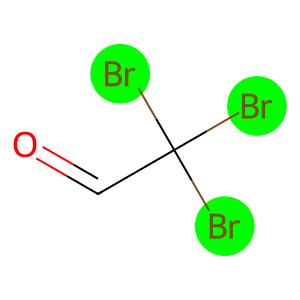

In [38]:
depict_identifier(training_data['ROMol'][8],3612926680, 1)

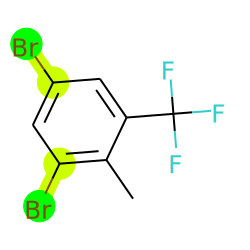

In [46]:
# Visualising the most similar pattern.
SVG(identifier_depictions['3632350815'][0])

In [47]:
model.wv.get_vector('3612926680')

array([-0.18752708,  0.06312975, -0.2161942 ,  0.32204887,  0.06985705,
        0.17172626, -0.15910377,  0.19972754, -0.18479478,  0.00887464,
        0.09369911, -0.24318564, -0.42698652, -0.04883337,  0.02502398,
        0.13546626, -0.08017507,  0.32639825,  0.10982613,  0.1610404 ,
        0.23677371,  0.16719022,  0.31333208,  0.07954779, -0.4094191 ,
       -0.24994573, -0.08628218, -0.06057374,  0.03076531,  0.04608051,
        0.08117385, -0.00567944, -0.18338495, -0.10180715, -0.25048074,
        0.11743135, -0.04284525, -0.08801278,  0.4075138 ,  0.12696072,
       -0.02805484, -0.11859362,  0.11113219, -0.25288185, -0.21822251,
        0.23477714, -0.03412642,  0.3666379 , -0.23961289,  0.2908415 ,
        0.07289647,  0.0347281 ,  0.11996058, -0.41345978, -0.24554087,
       -0.3040263 , -0.33643448,  0.01332738,  0.00348234, -0.05455551,
       -0.01139213, -0.12138707, -0.20974554, -0.12359346, -0.41574872,
       -0.00724271, -0.01566769,  0.04985045,  0.35638788, -0.05

### Training the Random Forest classifiers

In [50]:
# Selecing only relevant rows (removing the rows, where labels are missing)
training_ahr = training_data.dropna(subset=['nr-ahr']).reset_index(drop=True)
training_er = training_data.dropna(subset=['nr-er']).reset_index(drop=True)

testing_ahr = testing_data.dropna(subset=['nr-ahr']).reset_index(drop=True)
testing_er = testing_data.dropna(subset=['nr-er']).reset_index(drop=True)

In [65]:
# Vectorising the data
X_train_ahr = np.array([x.vec for x in training_ahr['mol2vec']])
y_train_ahr = np.array(training_ahr['nr-ahr'])
X_test_ahr = np.array([x.vec for x in testing_ahr['mol2vec']])
y_test_ahr = np.array(testing_ahr['nr-ahr'])

X_train_er = np.array([x.vec for x in training_er['mol2vec']])
y_train_er = np.array(training_er['nr-er'])
X_test_er = np.array([x.vec for x in testing_er['mol2vec']])
y_test_er = np.array(testing_er['nr-er'])

In [59]:
rf_classifier_ahr = RandomForestClassifier()
param_grid = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}

random_search = RandomizedSearchCV(estimator=rf_classifier_ahr, param_distributions=param_grid, n_iter=10,
                                   scoring='roc_auc', cv=KFold(n_splits=10, shuffle=True, random_state=1))
random_search.fit(X_train_ahr, y_train_ahr)

best_model_ahr = random_search.best_estimator_
test_prob_ahr = best_model_ahr.predict_proba(X_test_ahr)[:, 1]
test_pred_ahr = best_model_ahr.predict(X_test_ahr)
test_roc_auc_ahr = roc_auc_score(y_test_ahr, test_prob_ahr)
test_bal_acc_ahr = balanced_accuracy_score(y_test_ahr, test_pred_ahr)
print(f'Test ROC-AUC: {test_roc_auc_ahr:.4f}')
print(f'Test balanced accuracy: {test_bal_acc_ahr:.4f}')

Test ROC-AUC: 0.9025
Test balanced accuracy: 0.6235


In [62]:
best_model_ahr

RandomForestClassifier(max_depth=19, min_samples_leaf=2, min_samples_split=4,
                       n_estimators=682)

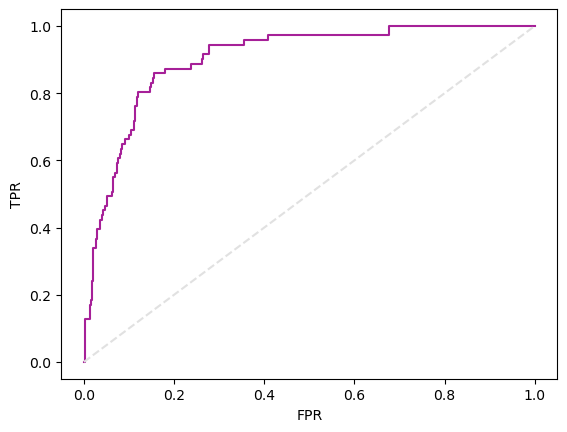

In [61]:
fpr_ahr, tpr_ahr, thresholds_ahr = roc_curve(y_test_ahr, test_prob_ahr)
plt.plot(fpr_ahr, tpr_ahr, c='#A62098')
plt.plot([0, 1], [0, 1], linestyle='--', c='#e1e1e1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [66]:
rf_classifier_er = RandomForestClassifier()
param_grid = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
}

random_search = RandomizedSearchCV(estimator=rf_classifier_er, param_distributions=param_grid, n_iter=10,
                                   scoring='roc_auc', cv=KFold(n_splits=10, shuffle=True, random_state=1))
random_search.fit(X_train_er, y_train_er)

best_model_er = random_search.best_estimator_
test_prob_er = best_model_er.predict_proba(X_test_er)[:, 1]
test_pred_er = best_model_er.predict(X_test_er)
test_roc_auc_er = roc_auc_score(y_test_er, test_prob_er)
test_bal_acc_er = balanced_accuracy_score(y_test_er, test_pred_er)
print(f'Test ROC-AUC: {test_roc_auc_er:.4f}')
print(f'Test balanced accuracy: {test_bal_acc_er:.4f}')

Test ROC-AUC: 0.7801
Test balanced accuracy: 0.5778


In [67]:
best_model_er

RandomForestClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=3,
                       n_estimators=561)

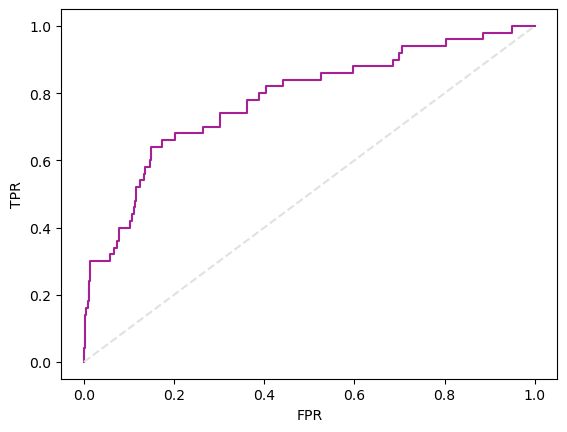

In [68]:
fpr_er, tpr_er, thresholds_er = roc_curve(y_test_er, test_prob_er)
plt.plot(fpr_er, tpr_er, c='#A62098')
plt.plot([0, 1], [0, 1], linestyle='--', c='#e1e1e1')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()